# Training Atari Donkey Kong with DQN

This notebook implements a DQN agent to play the Atari game Donkey Kong, with the following features:
- Parallel training across multiple game environments
- Game frame preprocessing for improved training efficiency
- Prioritized experience replay to enhance training quality
- Training log recording
- Regular model saving
- Periodic evaluation and game video recording

## 1. Installing Required Dependencies

In [17]:
# Install required libraries
# %pip install stable-baselines3[extra] gymnasium[atari] numpy matplotlib opencv-python tensorboard autorom[accept-rom-license] ipywidgets gymnasium[other]

## 2. Import Libraries

In [1]:

import os
import random
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.wrappers import RecordVideo, FrameStackObservation
import torch
print(torch.cuda.is_available())
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from collections import deque, namedtuple
from tqdm.notebook import tqdm
import cv2
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.atari_wrappers import AtariWrapper
import ale_py
from gymnasium import spaces

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

True


## 3. Configuration Parameters

In [2]:
# Environment parameters
ENV_NAME = "ALE/DonkeyKong-v5"
NUM_ENVS = 4  # Number of parallel environments
FRAME_SKIP = 4  # Frame skip, make decisions every 4 frames
ALLOWED_ACTIONS = [0,1,2,3,4,5,11,12]  # Valid actions

# Model parameters
BATCH_SIZE = 64
GAMMA = 0.99  # Discount factor
LEARNING_RATE = 0.0001
MEMORY_SIZE = 100000  # Experience replay buffer size
TARGET_UPDATE = 10000  # Target network update frequency

# Training parameters
NUM_FRAMES = 10_000_000  # Total training frames
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 6_000_000
DEMO_PATH = "./demo/dk_demo_20250325_192148.pkl"

# Save and evaluation parameters
SAVE_INTERVAL = 100_000  # Model save interval (frames)
EVAL_INTERVAL = 20_000   # Model evaluation interval (frames)
EVAL_EPISODES = 3        # Number of episodes per evaluation

# Create directories for saving models and logs
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
SAVE_PATH = f"./models/donkey_kong_{timestamp}"
LOG_PATH = f"./logs/donkey_kong_{timestamp}"
VIDEO_PATH = f"./videos/donkey_kong_{timestamp}"

for path in [SAVE_PATH, LOG_PATH, VIDEO_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

# Set device (GPU or CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Device: {device}")

Device: cpu


## 4. Environment Preprocessing

In [3]:
# Restrict action space, reduce agent's useless actions
class ActionRestrictWrapper(gym.ActionWrapper):
    def __init__(self, env, allowed_actions):
        super().__init__(env)
        self.allowed_actions = allowed_actions
        self.action_space = spaces.Discrete(len(self.allowed_actions))

    def action(self, act):
        # Map the action index output by the agent to the original action number
        return self.allowed_actions[act]

    def reverse_action(self, act):
        return self.allowed_actions.index(act)

# Wrapper that forces the first action to be FIRE
class ForceFirstFireWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.first_action_done = False
    
    def reset(self, **kwargs):
        self.first_action_done = False
        return self.env.reset(**kwargs)
    
    def step(self, action):
        # If it's the first action and not RIGHT FIRE, force replace it with RIGHT FIRE
        if not self.first_action_done:
            self.first_action_done = True
            # Use RIGHT FIRE action
            action_idx = ALLOWED_ACTIONS.index(11)
            return self.env.step(action_idx)
        return self.env.step(action)

# Function to detect player position based on color
def get_agent_position(frame): 
    """ Detect player position by color, return (x, y) coordinates. Returns None if not detected. """
    # Ensure frame is numpy array with correct format
    if frame is None:
        return None
    
    # Target color (BGR format)
    target_bgr = np.array([194, 64, 82], dtype=np.uint8)

    # Tolerance range (adjustable, usually 20~40 works well)
    tolerance = 30
    lower = np.array([max(0, c - tolerance) for c in target_bgr], dtype=np.uint8)
    upper = np.array([min(255, c + tolerance) for c in target_bgr], dtype=np.uint8)

    # Generate mask
    mask = cv2.inRange(frame, lower, upper)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Find the largest contour by area
    largest = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest)

    if M["m00"] == 0:
        return None

    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    return (cx, cy)

# Custom video display wrapper for showing actions and agent position
class VideoDisplayWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.current_action = None
        self.action_names = {
            0: "",
            1: "Jump",
            2: "Up",
            3: "Right",
            4: "Left",
            5: "Down",
            11: "Jump R",
            12: "Jump L"
        }
        
    def step(self, action):
        # Record current action
        self.current_action = action
        return self.env.step(action)
    
    def reset(self, **kwargs):
        self.current_action = None
        return self.env.reset(**kwargs)
    
    def render(self):
        # Get original rendered frame
        frame = self.env.render()
        
        if frame is None:
            return None
        
        # Ensure frame is RGB format
        if len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

        # 1. Display current action in top right corner
        if self.current_action is not None:
            action_name = self.action_names.get(self.current_action, f"ACTION_{self.current_action}")
            cv2.putText(frame, 
                       action_name, 
                       (frame.shape[1] - 85, 28), # Top right position
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       0.3,
                       (255, 255, 255), # White text
                       1, 
                       cv2.LINE_AA)
        
        return frame

# Custom reward wrapper to adjust rewards based on agent position changes
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env, y_static_penalty=0.1, up_success_reward=10,
                 up_fail_penalty=0, x_static_penalty=0,
                 y_threshold=20, x_threshold=3, 
                 y_static_frames=30, x_static_frames=30):
        super().__init__(env)
        # Reward parameters
        self.y_static_penalty = y_static_penalty  # Vertical static penalty
        self.up_success_reward = up_success_reward  # Successful upward movement reward
        self.up_fail_penalty = up_fail_penalty  # Failed upward movement penalty
        self.x_static_penalty = x_static_penalty  # Horizontal static penalty
        
        # Threshold parameters
        self.y_threshold = y_threshold  # Vertical movement threshold
        self.x_threshold = x_threshold  # Horizontal movement threshold
        self.y_static_frames = y_static_frames  # Vertical static frame count
        self.x_static_frames = x_static_frames  # Horizontal static frame count
        
        # State tracking
        self.prev_positions = []  # Store past positions [(x, y), ...]
        self.y_static_count = 0  # Vertical static counter
        self.x_static_count = 0  # Horizontal static counter
        self.prev_action = None  # Previous action
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Reset state tracking
        self.prev_positions = []
        self.y_static_count = 0
        self.x_static_count = 0
        self.prev_action = None
        return obs, info
    
    def step(self, action):
        # Record current action
        self.prev_action = action
        
        # Execute environment step
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Extract RGB frame from observation
        frame = None
        try:
            if isinstance(obs, np.ndarray):
                if len(obs.shape) == 4:  # (stack, height, width, channel)
                    frame = obs[-1]  # Last frame
                elif len(obs.shape) == 3:  # (height, width, channel)
                    frame = obs
                elif len(obs.shape) == 2:  # (height, width)
                    frame = obs
            elif hasattr(obs, '__getitem__'):
                # For FrameStackObservation
                try:
                    frame = obs[-1]
                except:
                    try:
                        frame = obs[3]  # Assuming 4 frame stack
                    except:
                        pass
            
            # If above attempts fail, try rendering the environment
            if frame is None:
                try:
                    frame = self.env.render()
                except:
                    pass
        except Exception as e:
            print(f"Failed to extract frame from observation: {e}")
            frame = None
        
        # Detect Agent position
        position = None
        if frame is not None:
            position = get_agent_position(frame)
        
        # If position detected, update position history and calculate reward adjustment
        additional_reward = 0
        
        if position is not None:
            x, y = position
            self.prev_positions.append((x, y))
            
            # Keep history at reasonable size
            if len(self.prev_positions) > max(self.y_static_frames, self.x_static_frames):
                self.prev_positions.pop(0)
            
            # Need at least two position records to determine movement
            if len(self.prev_positions) >= 2:
                prev_x, prev_y = self.prev_positions[-2]
                
                # 1. Check if vertically static
                if abs(y - prev_y) < self.y_threshold:
                    self.y_static_count += 1
                    if self.y_static_count >= self.y_static_frames:
                        # Linearly increasing penalty
                        additional_reward -= self.y_static_penalty * (self.y_static_count - self.y_static_frames + 1)
                else:
                    self.y_static_count = 0
                
                # 2. Check UP action effect
                if self.prev_action == 2:  # Assuming 2 is UP action
                    if (prev_y - y) > self.y_threshold:  # Successful upward movement
                        additional_reward += self.up_success_reward
                    else:  # Failed upward movement
                        additional_reward -= self.up_fail_penalty
                
                # 3. Check if horizontally static
                if abs(x - prev_x) < self.x_threshold:
                    self.x_static_count += 1
                    if self.x_static_count >= self.x_static_frames:
                        # Linearly increasing penalty
                        additional_reward -= self.x_static_penalty * (self.x_static_count - self.x_static_frames + 1)
                else:
                    self.x_static_count = 0
        
        # Apply reward adjustment
        adjusted_reward = reward + additional_reward
        
        return obs, adjusted_reward, terminated, truncated, info

# Function to create preprocessed environment
def make_env(env_id, idx, capture_video=False, run_name=None):
    def thunk():
        import ale_py
        
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            # Add video display wrapper
            env = VideoDisplayWrapper(env)
            env = RecordVideo(
                env,
                VIDEO_PATH,
                episode_trigger=lambda x: True,
                name_prefix=f"{run_name}"
            )
        else:
            env = gym.make(env_id)
        
        env = ActionRestrictWrapper(env, ALLOWED_ACTIONS)
        env = ForceFirstFireWrapper(env)
        env = CustomRewardWrapper(env)
        env = AtariWrapper(env, terminal_on_life_loss=True, frame_skip=FRAME_SKIP)
        env = FrameStackObservation(env, 4)  # Stack 4 frames to capture temporal information
            
        return env
    return thunk

# Create parallel environments
def make_vec_env(env_id, num_envs, seed=SEED):
    env_fns = [make_env(env_id, i) for i in range(num_envs)]
    envs = SubprocVecEnv(env_fns)
    envs.seed(seed)
    return envs

## 5. DQN Network Model

In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        # Input shape: (batch, stack_frames, height, width)
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

## 6. Prioritized Experience Replay

In [5]:
# Use prioritized experience replay to improve training efficiency
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha  # Controls the degree of prioritization
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1  # Current frame, used for beta calculation
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
    
    def beta_by_frame(self, frame_idx):
        # beta increases linearly from beta_start to 1.0
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, *args):
        # Add new experience
        max_prio = np.max(self.priorities) if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(self.Transition(*args))
        else:
            self.buffer[self.position] = self.Transition(*args)
        
        self.priorities[self.position] = max_prio
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]
        
        # Calculate sampling probabilities
        probs = prios ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        # Calculate importance sampling weights
        beta = self.beta_by_frame(self.frame)
        self.frame += 1
        
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, device=device, dtype=torch.float32)
        
        # Convert to batch processing format
        batch = self.Transition(*zip(*samples))
        states = torch.cat(batch.state)
        actions = torch.tensor(batch.action, device=device)
        rewards = torch.tensor(batch.reward, device=device, dtype=torch.float32)
        next_states = torch.cat(batch.next_state)
        dones = torch.tensor(batch.done, device=device, dtype=torch.float32)
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, indices, priorities):
        # Update priorities
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
    
    def __len__(self):
        return len(self.buffer)

## 7. DQN Agent

In [6]:
class DQNAgent:
    def __init__(self, state_shape, n_actions):
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        # Create policy network and target network
        self.policy_net = DQN(state_shape, n_actions).to(device)
        self.target_net = DQN(state_shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Target network doesn't need gradient calculation
        
        # Setup optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        
        # Create experience replay buffer
        self.memory = PrioritizedReplayBuffer(MEMORY_SIZE)
        
        # Training related parameters
        self.steps_done = 0
        self.epsilon = EPSILON_START
        
        # Logger
        self.writer = SummaryWriter(LOG_PATH)
    
    def select_action(self, state, eval_mode=False):
        # ε-greedy policy for action selection
        sample = random.random()
        # In evaluation mode, always choose the best action
        if eval_mode:
            eps_threshold = 0.05  # Use small epsilon in eval mode for some exploration
        else:
            # Linear epsilon decay
            self.epsilon = max(EPSILON_END, EPSILON_START - self.steps_done / EPSILON_DECAY)
            eps_threshold = self.epsilon
            
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
    
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return 0.0  # Not enough samples in buffer
        
        # Sample from experience replay buffer
        states, actions, rewards, next_states, dones, indices, weights = self.memory.sample(BATCH_SIZE)
        
        # Calculate current Q values
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Use Double DQN to calculate next state Q values
        # Use policy network to select actions
        next_actions = self.policy_net(next_states).max(1)[1].unsqueeze(1)
        # Use target network to evaluate actions
        next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze(1)
        # Set next Q values for terminal states to 0
        next_q_values = next_q_values * (1 - dones)
        # Calculate target Q values
        target_q_values = rewards + GAMMA * next_q_values
        
        # Calculate loss (TD error)
        td_error = torch.abs(q_values - target_q_values).detach().cpu().numpy()
        loss = F.smooth_l1_loss(q_values, target_q_values, reduction='none') * weights
        loss = loss.mean()
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()
        
        # Update priorities
        self.memory.update_priorities(indices, td_error + 1e-5)
        
        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save_model(self, path):
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps_done': self.steps_done,
            'epsilon': self.epsilon
        }, path)
    
    def load_model(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps_done = checkpoint['steps_done']
        self.epsilon = checkpoint['epsilon']

## 8. Observation Preprocessing and State Transformation Functions

In [7]:
def preprocess_observation(obs):
    # Convert stacked 4 frames to PyTorch input format
    frames = np.array(obs).squeeze(-1)
    tensor = torch.tensor(frames, dtype=torch.float32, device=device).unsqueeze(0)
    return tensor / 255.0  # Normalize

def preprocess_batch_observation(obs):
    # Process batch observation data
    frames = np.array(obs).squeeze(-1)
    tensor = torch.tensor(frames, dtype=torch.float32, device=device)
    return tensor / 255.0  # Normalize

## 9. Evaluation Function

In [8]:
def evaluate(agent, env_id, num_episodes=5, video_prefix="evaluation"):
    episode_rewards = []
    
    # Create a new environment instance for each evaluation episode
    for i in range(num_episodes):
        # Create new environment instance for each game round
        env = make_env(env_id, 0, capture_video=True, run_name=f"{video_prefix}_episode_{i}")()
        
        obs, _ = env.reset()
        obs_tensor = preprocess_observation(obs)
        done = False
        total_reward = 0.0
        
        while not done:
            action = agent.select_action(obs_tensor, eval_mode=True).item()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            obs = next_obs
            obs_tensor = preprocess_observation(obs)

        episode_rewards.append(total_reward)
        env.close()  # Close the environment after each episode

        # Modify video filename, remove extra suffix
        video_path = os.path.abspath(os.path.join(VIDEO_PATH, f"{video_prefix}_episode_{i}-episode-0.mp4"))
        if os.path.exists(video_path):
            new_video_path = video_path.replace("-episode-0.mp4", ".mp4")
            os.rename(video_path, new_video_path)
    
    return np.mean(episode_rewards), np.std(episode_rewards), episode_rewards

## 10. Training Functions

In [9]:
def train(agent, envs, num_frames):
    # Initialize environment and progress bar
    obs = envs.reset()
    obs_tensor = preprocess_batch_observation(obs)
    
    losses = []
    all_rewards = []
    episode_reward = np.zeros(NUM_ENVS)
    episode_length = np.zeros(NUM_ENVS)
    
    progress_bar = tqdm(range(1, num_frames + 1), desc="Training")
    
    # Training loop
    for frame_idx in progress_bar:
        # Select actions
        actions = []
        for i in range(NUM_ENVS):
            action = agent.select_action(obs_tensor[i:i+1])
            actions.append(action.item())
        
        # Execute actions
        next_obs, rewards, terminateds, truncateds = envs.step(actions)
        
        # Process data for each environment
        dones = []
        for t, tr in zip(terminateds, truncateds):
            if isinstance(tr, dict):
                done = t or tr.get("TimeLimit.truncated", False)
            else:
                done = t or tr
            dones.append(done)

        next_obs_tensor = preprocess_batch_observation(next_obs)
        
        # Update cumulative rewards and episode length
        episode_reward += rewards
        episode_length += 1
        
        # Store data in experience replay buffer
        for i in range(NUM_ENVS):
            agent.memory.push(
                obs_tensor[i:i+1],
                actions[i],
                rewards[i],
                next_obs_tensor[i:i+1],
                float(dones[i])
            )
        
        # Update observations
        obs = next_obs
        obs_tensor = next_obs_tensor
        
        # Optimize model
        loss = agent.optimize_model()
        losses.append(loss)
        
        # Check for episode completion
        for i, done in enumerate(dones):
            if done:
                # Record episode results
                agent.writer.add_scalar("train/episode_reward", episode_reward[i], agent.steps_done)
                agent.writer.add_scalar("train/episode_length", episode_length[i], agent.steps_done)
                all_rewards.append(episode_reward[i])
                
                # Reset episode statistics
                episode_reward[i] = 0
                episode_length[i] = 0
        
        # Update target network
        if frame_idx % TARGET_UPDATE == 0:
            agent.update_target_network()
        
        # Record training statistics
        if frame_idx % 1000 == 0:
            mean_reward = np.mean(all_rewards[-100:]) if all_rewards else 0
            mean_loss = np.mean(losses[-100:]) if losses else 0
            agent.writer.add_scalar("train/epsilon", agent.epsilon, frame_idx)
            agent.writer.add_scalar("train/loss", mean_loss, frame_idx)
            agent.writer.add_scalar("train/mean_reward_100", mean_reward, frame_idx)
            
            progress_bar.set_postfix({
                "avg_reward": f"{mean_reward:.2f}",
                "loss": f"{mean_loss:.5f}",
                "epsilon": f"{agent.epsilon:.2f}"
            })
        
        # Save model
        if frame_idx % SAVE_INTERVAL == 0:
            save_path = os.path.join(SAVE_PATH, f"model_{frame_idx}.pt")
            agent.save_model(save_path)
            print(f"\nFrame {frame_idx}: Model saved to {save_path}")
        
        # Evaluate model
        if frame_idx % EVAL_INTERVAL == 0:
            print(f"\nFrame {frame_idx}: Evaluating...")
            eval_reward, eval_std, _ = evaluate(
                agent,
                ENV_NAME,
                num_episodes=EVAL_EPISODES,
                video_prefix=f"eval_{frame_idx}"
            )
            agent.writer.add_scalar("eval/mean_reward", eval_reward, frame_idx)
            agent.writer.add_scalar("eval/reward_std", eval_std, frame_idx)
            print(f"Evaluation results: Mean reward = {eval_reward:.2f} ± {eval_std:.2f}")
        
        # Update agent's step counter
        agent.steps_done += 1
    
    # Save final model after training
    final_path = os.path.join(SAVE_PATH, "model_final.pt")
    agent.save_model(final_path)
    print(f"\nFinal model saved to: {final_path}")


def load_demonstrations(agent, filepath):
    """Load demonstration trajectories from file and inject them into the agent's replay buffer"""
    import pickle

    # Use the same ALLOWED_ACTIONS as in training
    ALLOWED_ACTIONS = [0,1,2,3,4,5,11,12]
    action_to_index = {a: i for i, a in enumerate(ALLOWED_ACTIONS)}

    with open(filepath, 'rb') as f:
        all_trajectories = pickle.load(f)

    count = 0
    skipped = 0
    for traj in all_trajectories:
        for s, a, r, ns, d in traj:
            if a not in action_to_index:
                print(f"Skipping illegal action: {a}")
                skipped += 1
                continue
            
            action_index = action_to_index[a]  # Map to 0~7

            agent.memory.push(
                s.to(device),
                action_index,
                r.to(device),
                ns.to(device),
                d.to(device)
            )
            count += 1

    print(f"\nDemonstrations imported, {count} transitions added to replay buffer. Skipped {skipped} illegal actions.\n")

## 11. Main Training Process

In [10]:
# Create parallel environments
envs = make_vec_env(ENV_NAME, NUM_ENVS)

# Get environment information
obs_shape = (4, 84, 84)  # 4 stacked frames, each 84x84
n_actions = envs.action_space.n

print(f"\nObservation shape: {obs_shape}")
print(f"Action space size: {n_actions}")



Observation shape: (4, 84, 84)
Action space size: 8


In [11]:

# Create DQN agent
agent = DQNAgent(obs_shape, n_actions)

# Load demonstration trajectories if available
if DEMO_PATH and os.path.exists(DEMO_PATH):
    Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
    load_demonstrations(agent, DEMO_PATH)
else:
    print(f"Demonstration file not found at {DEMO_PATH}, skipping demonstration loading.")



Demonstrations imported, 2448 transitions added to replay buffer. Skipped 0 illegal actions.



In [12]:
# # Start training
# print("\nTraining started...\n")

# # Enable cudnn benchmark mode to improve training speed
# torch.backends.cudnn.benchmark = True

# train(agent, envs, NUM_FRAMES)

# # Close environments
# envs.close()

## 12. Load and Test Trained Models

In [18]:
def play_and_record_video(model_path, env_id, num_episodes=5):
    # Create agent and load model
    obs_shape = (4, 84, 84)  # 4 stacked frames, each 84x84
    env = make_env(env_id, 0)()
    n_actions = env.action_space.n
    agent = DQNAgent(obs_shape, n_actions)
    agent.load_model(model_path)
    
    # Test trained agent
    mean, std, rewards = evaluate(agent, env_id, num_episodes=num_episodes, video_prefix="final_test")

    for i, reward in enumerate(rewards):
        print(f"Episode {i+1}: Reward = {reward}")
        
    print(f"\nAverage reward: {mean:.2f} ± {std:.2f}")

In [20]:
# Load and test the final model
# model_path = os.path.join(SAVE_PATH, "model_final.pt")
model_path = "./model_final.pt"
play_and_record_video(model_path, ENV_NAME, num_episodes=5)

Episode 1: Reward = -34.0
Episode 2: Reward = -34.0
Episode 3: Reward = -33.0
Episode 4: Reward = -32.0
Episode 5: Reward = -38.0

Average reward: -34.20 ± 2.04


## 13. Visualizing Training Results

In [15]:
# Use TensorBoard to visualize training results
print(f"To visualize training results, run the following command in the terminal:")
print(f"tensorboard --logdir={LOG_PATH}")

To visualize training results, run the following command in the terminal:
tensorboard --logdir=./logs/donkey_kong_20250410_140343


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\sreeh\miniconda3\envs\donkey2\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
    from tensorboard.main import run_main
  File "C:\Users\sreeh\miniconda3\envs\donkey2\Lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "C:\Users\sreeh\miniconda3\envs\donkey2\Lib\site-packages\tensorboard\default.py", line 40, in <module>
    from tensorboard.plugins.image import images_plugin
  File "C:\Users\sreeh\miniconda3\envs\donkey2\Lib\site-packages\tensorboard\plugins\image\images_plugin.py", line 18, in <module>
    import imghdr
ModuleNotFoundError: No module named 'imghdr'

Extracting and plotting TensorBoard metrics...


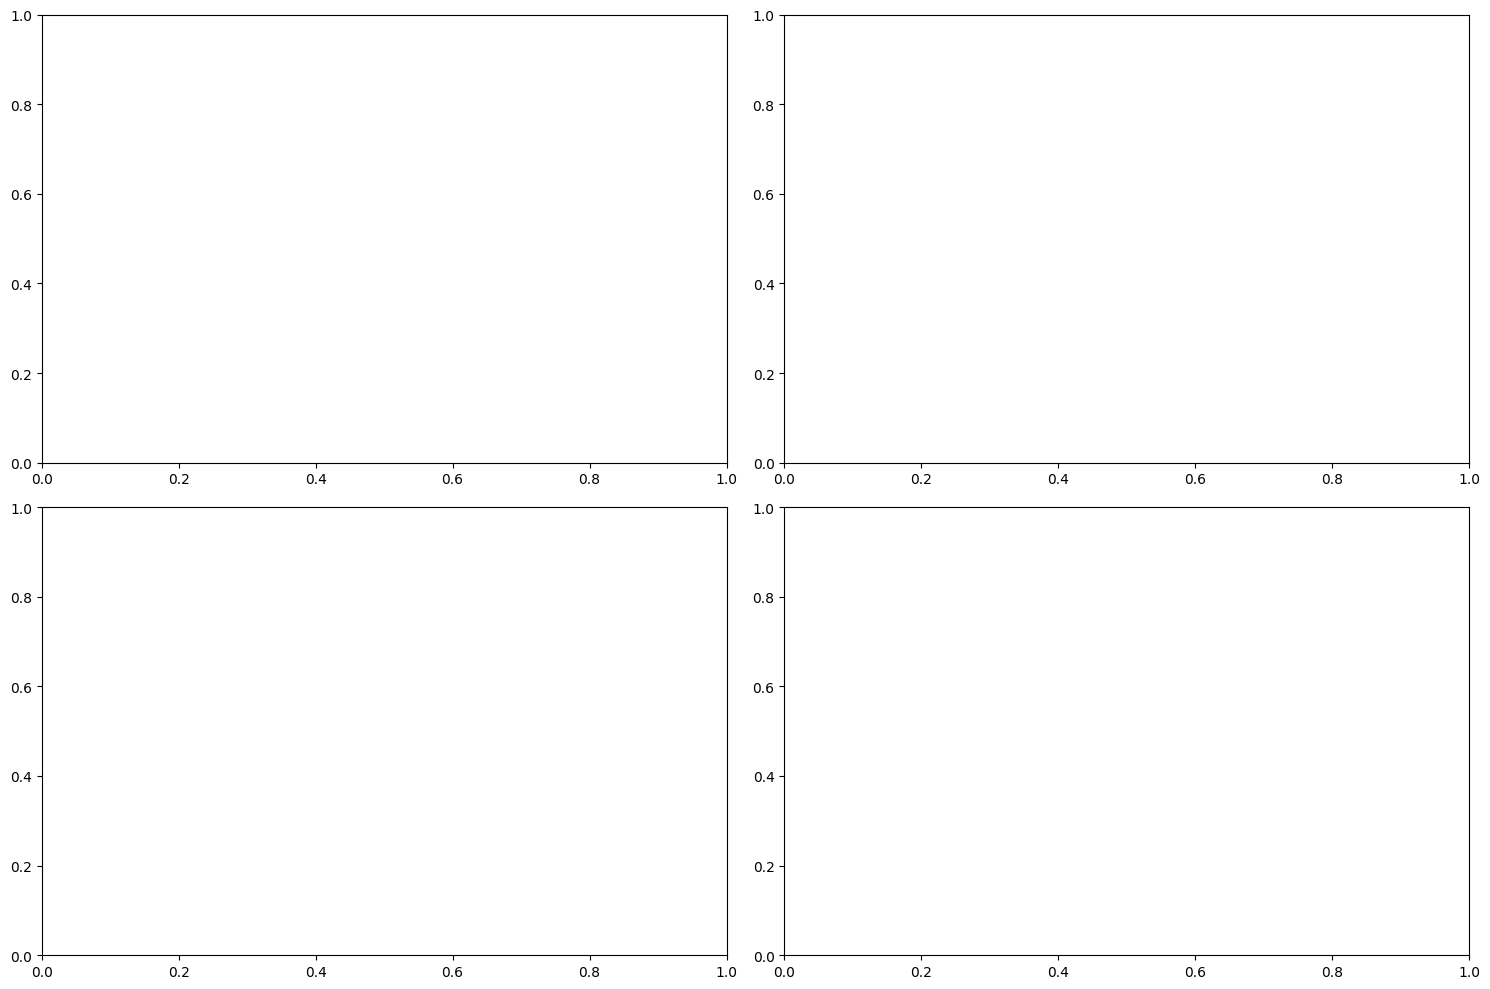


Training Summary Statistics:


In [16]:
from tensorboard import notebook
import pandas as pd
import os
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

# Visualize TensorBoard logs in Jupyter notebook
import matplotlib.pyplot as plt

# Load TensorBoard extension
%load_ext tensorboard

# Start TensorBoard in the notebook
%tensorboard --logdir={LOG_PATH}

# Alternatively, extract and plot data directly with matplotlib
def plot_tensorboard_data(log_dir):
    """Extract and plot key metrics from TensorBoard logs"""
    
    # Load the event file
    ea = event_accumulator.EventAccumulator(log_dir, 
        size_guidance={
            event_accumulator.SCALARS: 0,  # 0 means load all
        })
    ea.Reload()
    
    # Get available tags (metrics)
    tags = ea.Tags()['scalars']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Metrics to plot
    key_metrics = [
        'train/mean_reward_100', 
        'train/epsilon', 
        'train/loss',
        'eval/mean_reward'
    ]
    
    # Plot each metric
    for i, metric in enumerate(key_metrics):
        if metric in tags:
            events = ea.Scalars(metric)
            steps = [event.step for event in events]
            values = [event.value for event in events]
            
            ax = axes[i]
            ax.plot(steps, values)
            ax.set_title(metric)
            ax.set_xlabel('Training Steps')
            ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create a dataframe with all metrics for more detailed analysis
    metrics_dict = {}
    for tag in tags:
        events = ea.Scalars(tag)
        metrics_dict[tag] = {event.step: event.value for event in events}
    
    # Convert to pandas DataFrame for easy analysis
    all_steps = sorted(set().union(*[set(d.keys()) for d in metrics_dict.values()]) if metrics_dict else [])
    df = pd.DataFrame(index=all_steps)
    
    for tag, values in metrics_dict.items():
        df[tag] = pd.Series(values)
    
    return df

# Plot the data
print("Extracting and plotting TensorBoard metrics...")
try:
    metrics_df = plot_tensorboard_data(LOG_PATH)

    # Display summary statistics
    print("\nTraining Summary Statistics:")
    for col in metrics_df.columns:
        if 'reward' in col:
            print(f"{col}:")
            print(f"  Max: {metrics_df[col].max():.2f}")
            print(f"  Last: {metrics_df[col].iloc[-1] if not pd.isna(metrics_df[col].iloc[-1]) else np.nan:.2f}")
            print(f"  Mean: {metrics_df[col].mean():.2f}")
except Exception as e:
    print(f"Error processing TensorBoard data: {e}")
    print("Check if the log directory exists and contains valid TensorBoard event files.")